# Airline Clustering Model
**Author:** Sterling Hayden

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

## Dimension Reduction Pre-Processing

In [26]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('./Data_Files/Flights_Wrangled_Old.csv')

# Filter to only delays
df = df[df['DepDelayMinutes'] > 0]

# create hour column
df['CRSDepTime'] = df['CRSDepTime'].astype(str).str.zfill(4)
df['DepHour'] = df['CRSDepTime'].str[:2].astype(int)
df.head()

C:\Users\rvenka23\AppData\Local\Temp\2\ipykernel_20956\2052006380.py:2: DtypeWarning: Columns (78,85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./Data_Files/Flights_Wrangled_Old.csv')


,Year,Quarter,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,DOT_ID_Marketing_Airline,Operating_Airline.,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,Origin,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,Dest,DestCityName,DestState,DestStateFips,DestStateName,DestWac,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Flights,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,LongestAddGTime,DivAirportLandings,DivReachedDest,DivActualElapsedTime,DivArrDelay,DivDistance,Div1Airport,Div1AirportID,Div1AirportSeqID,Div1WheelsOn,Div1TotalGTime,Div1LongestGTime,Div1WheelsOff,Div1TailNum,Div2Airport,Div2AirportID,Div2AirportSeqID,Div2WheelsOn,Div2TotalGTime,Div2LongestGTime,Div2WheelsOff,Div2TailNum,DepHour
0,2022,2,1,5,2022-04-01,WN,19393,WN,19393,WN,N903WN,649,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,0820,832.0,12.0,12.0,0.0,0.0,0800-0859,13.0,845.0,1000.0,4.0,1000,1004.0,4.0,4.0,0.0,0.0,1000-1059,0,NaN,0,160.0,152.0,135.0,1,813,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
1,2022,2,1,5,2022-04-01,WN,19393,WN,19393,WN,N8655D,1057,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,1440,1505.0,25.0,25.0,1.0,1.0,1400-1459,11.0,1516.0,1625.0,7.0,1615,1632.0,17.0,17.0,1.0,1.0,1600-1659,0,NaN,0,155.0,147.0,129.0,1,813,4,12.0,0.0,0.0,0.0,5.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
2,2022,2,1,5,2022-04-01,WN,19393,WN,19393,WN,N763SW,1765,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10423,1042302,30423,AUS,"Austin, TX",TX,48,Texas,74,1955,2105.0,70.0,70.0,1.0,4.0,1900-1959,18.0,2123.0,2232.0,5.0,2135,2237.0,62.0,62.0,1.0,4.0,2100-2159,0,NaN,0,160.0,152.0,129.0,1,813,4,4.0,0.0,0.0,0.0,58.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
3,2022,2,1,5,2022-04-01,WN,19393,WN,19393,WN,N264LV,5,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10693,1069302,30693,BNA,"Nashville, TN",TN,47,Tennessee,54,1510,1547.0,37.0,37.0,1.0,2.0,1500-1559,14.0,1601.0,1539.0,8.0,1510,1547.0,37.0,37.0,1.0,2.0,1500-1559,0,NaN,0,60.0,60.0,38.0,1,214,1,37.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15
5,2022,2,1,5,2022-04-01,WN,19393,WN,19393,WN,N425LV,3507,10397,1039707,30397,ATL,"Atlanta, GA",GA,13,Georgia,34,10693,1069302,30693,BNA,"Nashville, TN",TN,47,Tennessee,54,2225,2251.0,26.0,26.0,1.0,1.0,2200-2259,9.0,2300.0,2237.0,16.0,2235,2253.0,18.0,18.0,1.0,1.0,2200-2259,0,NaN,0,70.0,62.0,37.0,1,214,1,0.0,0.0,0.0,0.0,18.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22


In [27]:
# Features we're interested in
num_features = ['DepDelayMinutes', 'TaxiOut', 'TaxiIn', 'Distance',] 
unchange_features = ['DepDel15']
non_Ord_features = ['IATA_Code_Operating_Airline', 'Origin', 'Dest']
Ord_features = ['DayOfWeek', 'DistanceGroup', 'DepHour']
all = num_features + unchange_features + non_Ord_features + Ord_features
df = df[all]
df.head()

,DepDelayMinutes,TaxiOut,TaxiIn,Distance,DepDel15,IATA_Code_Operating_Airline,Origin,Dest,DayOfWeek,DistanceGroup,DepHour
0,12.0,13.0,4.0,813,0.0,WN,ATL,AUS,5,4,8
1,25.0,11.0,7.0,813,1.0,WN,ATL,AUS,5,4,14
2,70.0,18.0,5.0,813,1.0,WN,ATL,AUS,5,4,19
3,37.0,14.0,8.0,214,1.0,WN,ATL,BNA,5,1,15
5,26.0,9.0,16.0,214,1.0,WN,ATL,BNA,5,1,22


In [28]:
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

df.to_csv('./Data_Files/Clustering_Data/Un_Encoded.csv', index=False)
df.head()

,DepDelayMinutes,TaxiOut,TaxiIn,Distance,DepDel15,IATA_Code_Operating_Airline,Origin,Dest,DayOfWeek,DistanceGroup,DepHour
0,0.003679,0.054299,0.011765,0.157985,0.0,WN,ATL,AUS,5,4,8
1,0.008027,0.045249,0.023529,0.157985,1.0,WN,ATL,AUS,5,4,14
2,0.023077,0.076923,0.015686,0.157985,1.0,WN,ATL,AUS,5,4,19
3,0.012040,0.058824,0.027451,0.030102,1.0,WN,ATL,BNA,5,1,15
5,0.008361,0.036199,0.058824,0.030102,1.0,WN,ATL,BNA,5,1,22


## Aggregating Departure Delays

In [29]:
df = pd.read_csv('./Data_Files/Clustering_Data/Un_Encoded.csv')
pd.set_option('display.max_columns', None)

df = df.drop(columns=['TaxiIn', 'Distance', 'DepDel15', 'Dest', 'DistanceGroup', 'Origin'])
df.head()

,DepDelayMinutes,TaxiOut,IATA_Code_Operating_Airline,DayOfWeek,DepHour
0,0.003679,0.054299,WN,5,8
1,0.008027,0.045249,WN,5,14
2,0.023077,0.076923,WN,5,19
3,0.012040,0.058824,WN,5,15
4,0.008361,0.036199,WN,5,22


In [30]:
agg_funcs = {
    'DepDelayMinutes': ['median'],
    'TaxiOut': ['median'],
}

median_delay_by_time_air = df.groupby(['IATA_Code_Operating_Airline', 'DayOfWeek', 'DepHour']).agg(agg_funcs).reset_index()
median_delay_by_time_air.columns = ['Airline', 'DayOfWeek', 'DepHour', 'DepDelayMinutesMedian', 'TaxiOutMedian']

median_delay_by_time_air.to_csv('./Data_Files/Clustering_Data/Med_DepDelay_by_Features.csv', index=False)
median_delay_by_time_air

,Airline,DayOfWeek,DepHour,DepDelayMinutesMedian,TaxiOutMedian
0,AA,1,0,0.003010,0.063348
1,AA,1,1,0.003679,0.058824
2,AA,1,2,0.004682,0.067873
3,AA,1,5,0.002508,0.058824
4,AA,1,6,0.004013,0.067873
...,...,...,...,...,...
1316,WN,7,19,0.007023,0.049774
1317,WN,7,20,0.007358,0.049774
1318,WN,7,21,0.007023,0.049774
1319,WN,7,22,0.008027,0.045249


## Hierarchical Clustering

In [31]:
df2 = pd.read_csv('./Data_Files/Clustering_Data/Med_DepDelay_by_Features.csv')
pd.set_option('display.max_columns', None)

airline_mapping = {
    'AA': 'American',
    'F9': 'Frontier',
    'NK': 'Spirit',
    'UA': 'United',
    'B6': 'JetBlue',
    'DL': 'Delta',
    'AS': 'Alaska',
    'WN': 'Southwest',
    'G4': 'Allegiant',
    'HA': 'Hawaiian'
}
df2['Airline'] = df2['Airline'].replace(airline_mapping)

df2.head()

,Airline,DayOfWeek,DepHour,DepDelayMinutesMedian,TaxiOutMedian
0,American,1,0,0.003010,0.063348
1,American,1,1,0.003679,0.058824
2,American,1,2,0.004682,0.067873
3,American,1,5,0.002508,0.058824
4,American,1,6,0.004013,0.067873


In [32]:
pivot_table = df2.pivot_table(index='Airline', columns=['DayOfWeek', 'DepHour'], values=['DepDelayMinutesMedian']).fillna(0)
pivot_table.head()

DepDelayMinutesMedian                                          \
DayOfWeek                     1                                           
DepHour                      0         1         2         5         6    
Airline                                                                   
Alaska                 0.005017  0.000000  0.000000  0.001003  0.002676   
Allegiant              0.000000  0.000000  0.000000  0.000000  0.002676   
American               0.003010  0.003679  0.004682  0.002508  0.004013   
Delta                  0.004348  0.000000  0.000000  0.002843  0.002676   
Frontier               0.011371  0.009365  0.000000  0.003344  0.004682   

                                                                       \
DayOfWeek                                                               
DepHour          7         8         9         10        11        12   
Airline                                                                 
Alaska     0.005017  0.004181  0.004013  0.003846  0.004013  0.007023   
Allegiant  0.002174  0.005853  0.008528  0.004348  0.006355  0.003679   
American   0.003846  0.003679  0.003679  0.004348  0.004682  0.005017   
Delta      0.003010  0.003344  0.003679  0.003679  0.004013  0.003679   
Frontier   0.005017  0.007023  0.005686  0.006355  0.007358  0.007692   

                                                                       \
DayOfWeek                                                               
DepHour          13        14        15        16        17        18   
Airline                                                                 
Alaska     0.004348  0.005017  0.005351  0.007023  0.004682  0.006020   
Allegiant  0.006020  0.006020  0.007692  0.008528  0.009365  0.012375   
American   0.006355  0.006355  0.007358  0.006689  0.007023  0.007358   
Delta      0.004013  0.003679  0.004013  0.005351  0.005351  0.006355   
Frontier   0.008528  0.009030  0.008361  0.009030  0.009365  0.009699   

                                                                       \
DayOfWeek                                                           2   
DepHour          19        20        21        22        23        0    
Airline                                                                 
Alaska     0.005184  0.005351  0.004682  0.005686  0.005017  0.007023   
Allegiant  0.010368  0.014047  0.000000  0.043478  0.008361  0.000000   
American   0.007358  0.007358  0.006689  0.006355  0.004348  0.003010   
Delta      0.005351  0.006020  0.005017  0.005351  0.006020  0.004181   
Frontier   0.012375  0.009699  0.010702  0.011037  0.009030  0.010368   

                                                                       \
DayOfWeek                                                               
DepHour          1         4         5         6         7         8    
Airline                                                                 
Alaska     0.000000  0.000000  0.000000  0.006020  0.004515  0.005351   
Allegiant  0.000000  0.000000  0.000000  0.004682  0.013378  0.002676   
American   0.001338  0.000000  0.002676  0.004013  0.004013  0.004013   
Delta      0.000000  0.000000  0.002341  0.002007  0.003010  0.003344   
Frontier   0.010702  0.005017  0.004348  0.004348  0.008361  0.005686   

                                                                       \
DayOfWeek                                                               
DepHour          9         10        11        12        13        14   
Airline                                                                 
Alaska     0.003177  0.004348  0.003344  0.005686  0.006355  0.003344   
Allegiant  0.004849  0.003010  0.008361  0.001003  0.005017  0.005518   
American   0.004013  0.004348  0.004348  0.005017  0.005351  0.005686   
Delta      0.003010  0.003344  0.004013  0.004013  0.003846  0.004013   
Frontier   0.008696  0.005351  0.005017  0.006020  0.005351  0.008027   

                                            

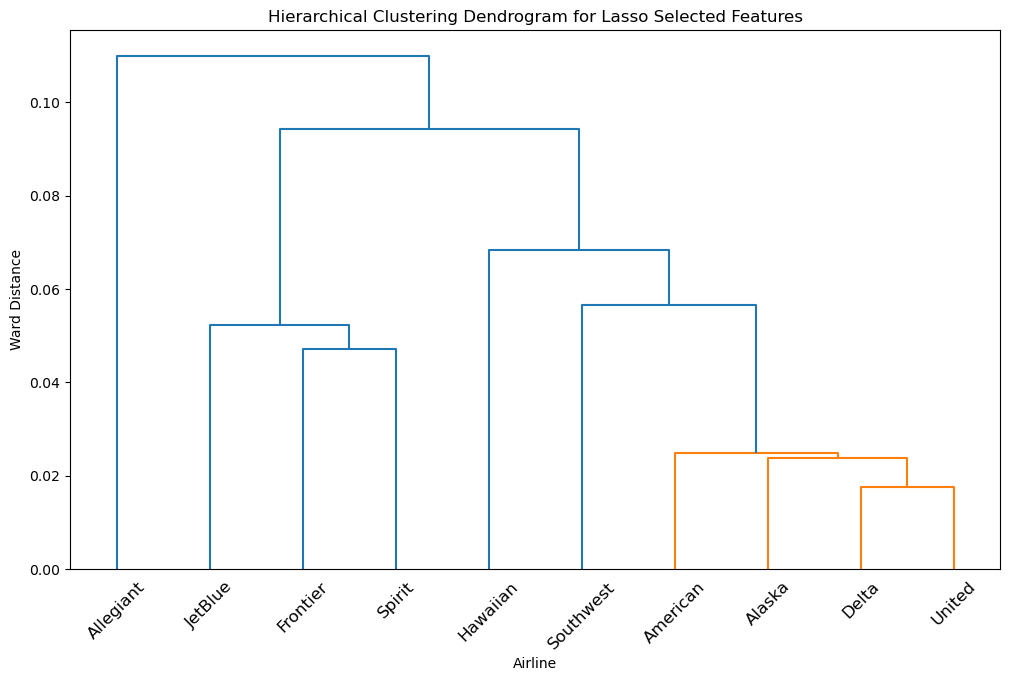

In [33]:
# Perform hierarchical clustering
plt.figure(figsize=(12, 7))
#dendrogram = sch.dendrogram(sch.linkage(pivot_table, method='ward'), labels=pivot_table.index)
Z = sch.linkage(pivot_table, method='ward')
dendrogram = sch.dendrogram(Z, labels=pivot_table.index, color_threshold=0.4*max(Z[:,2]))

plt.title("Hierarchical Clustering Dendrogram for Lasso Selected Features")
plt.xlabel("Airline")
plt.ylabel("Ward Distance")
plt.xticks(rotation=45)

plt.show()

**Dendrogram Explanation:** https://cdn-dfnaj.nitrocdn.com/xxeFXDnBIOflfPsgwjDLywIQwPChAOzV/assets/images/optimized/rev-630e2e6/www.displayr.com/wp-content/uploads/2018/03/Screen-Shot-2018-03-28-at-11.48.48-am.png